# Naive implementation of statevector simulation

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [28]:
# Gate Definitions
X = np.array([[0, 1], [1, 0]])
H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
I = np.eye(2)
CNOT = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1],
                 [0, 0, 1, 0]])

In [29]:
import pennylane as qml
import pennylane.numpy as np

#### Quantum Circuit simulation using Pennylane

In [30]:
def apply_quantum(qubits):
    dev = qml.device("default.qubit", wires=qubits)

    @qml.qnode(dev)
    def circuit(qubits):
        for wire in range(qubits-1):
            qml.QubitUnitary(X, wires=wire)
            qml.QubitUnitary(H, wires=wire)
            qml.QubitUnitary(CNOT, wires=[wire,wire+1])
        qml.QubitUnitary(X, wires=qubits-1)
        qml.QubitUnitary(H, wires=qubits-1)
        return qml.state()
    
    state = circuit(qubits)
    return state

In [31]:
# Run Circuit with Matrix Multiplication
state1 = apply_quantum(4)
state1

tensor([ 0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j,
        -0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,
        -0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j], requires_grad=True)

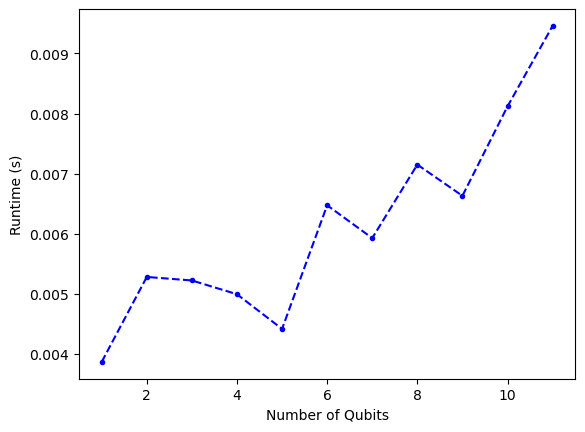

In [44]:
# Runtime Plot
qubits = range(1, 12)
times = []
states = []
for n in qubits:
    start = time.time()
    states.append(apply_quantum(n))
    times.append(time.time() - start)

plt.plot(qubits, times,marker = ".",ls = "--",c="b")
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.show()

### Using only matrix multiplication

In [33]:
def direct_sum(a, b):
    m1, n1 = a.shape
    m2, n2 = b.shape
    c = np.zeros((m1 + m2, n1 + n2))
    
    c[:m1, :n1] = a   
    c[m1:, n1:] = b
    return c

In [34]:
# so we already have our operators, now we will calculate time required for computation.

def init_state(qubits):
    state = [1,0]
    for _ in range(qubits-1):
        state = np.kron(state,[1,0])
    return state

In [35]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.quantum_info import Operator

def cnot_op(qubits):
    c = QuantumCircuit(qubits)
    for i in range(qubits-1):
        c.cx(i+1,i)  
    #gate = c.to_gate()
    #matrix = c.to_matrix()
    matrix = Operator.from_circuit(c)
    return matrix.data

In [36]:
print(cnot_op(2))

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]]


In [37]:
def apply_numpy(qubits):
    initial = init_state(qubits)
    xop= 1
    hop= 1
    cnotop = cnot_op(qubits)
    for _ in range(qubits):
        xop = np.kron(xop,X)
        hop = np.kron(hop,H)
    
    state_vec = np.dot(xop,initial)
    state_vec = np.dot(hop,state_vec)
    state_vec = np.dot(cnotop,state_vec)
    
    return state_vec

In [38]:
# Run Circuit with Matrix Multiplication
state2 = apply_numpy(4)
state2

tensor([ 0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j,
        -0.25+0.j,  0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,
        -0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j], requires_grad=True)

^^ in the tensor result above the apply function should give the same value for both quantum and numpy methods but upon closer inspection some signs are wrong. please check code and source of error.

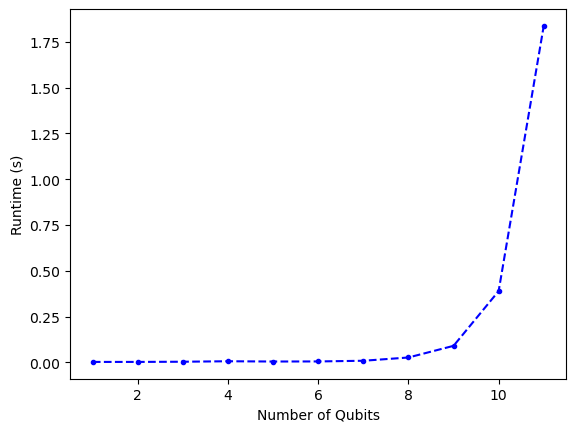

In [43]:
# Runtime Plot
qubits = range(1, 12)
times = []
states = []
for n in qubits:
    start = time.time()
    states.append(apply_numpy(n))
    times.append(time.time() - start)

plt.plot(qubits, times,marker = ".",ls = "--",c="b")
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.show()